# ML-Fundamentals - Exercise - Mutual Information for Feature Selection

## Table of Contents
* [Introduction](#Introduction)
* [Requirements](#Requirements) 
  * [Knowledge](#Knowledge)
  * [Modules](#Python-Modules)
* [Teaching Content](#Teaching-Content)
  * [Expected Mutual Information and Kullback Leibler Divergence](#Expected-Mutual-Information-and-Kullback-Leibler-Divergence)
  * [Information Gain](#Information-Gain)
* [Preparing the Documents](#Preparing-the-Documents)
    * [Loading the Dataset](#Loading-the-Dataset)
    * [Vectorization](#From-Documents-to-Feature-Vectors)
    * [Review](#Review)
* [Exercise - Mutual Information](#Exercise---Mutual-Information)
* [Training a Feature Selector](#Training-a-Feature-Selector)
    * [Testing our Selection](#Testing-our-Selection)
* [Literature](#Literature)
* [Licenses](#Licenses)

## Introduction

In this notebook you will be dealing with feature selection. You will be presented with a binary classification problem in which documents belong to one of two categories. We will be using the presence or absence of terms from a document to predict its category. 

Our aim is to avoid checking for the presence or absence of each possible term in a given document. Some features carry more weight in making a prediction that others, so ideally using only a selected subset of terms in our classification should suffice.

This process is called **feature selection**. One of the ways to measure how much a feature contributes to the classification is **mutual information**.

Your task will be to work out the terms we ought to select when using only a limited number of features.

## Requirements

### Knowledge

To complete this exercise notebook you should possess knowledge about the following topics.
* Feature selection
* Mutual information
* optional: Kullback Leibler Divergence

The following literature can help you to acquire this knowledge:
* Chapter 13.5 "Feature Selection" of *Introduction to Information Retrieval* [[IIR]](#IIR). The introduction defines and discusses the motivation behind feature selection. 13.5.1 in particular explains the approach of mutual information.
* For a review of the state-of-the-art of feature selection methods based
on mutual information see [[VER14]](#VER14).
* Later in the notebook we use Bernoulli Naive Bayes for classification from scikit learn. If you want to learn 
more about this kind of classifier study Chapter 13.3 "The Bernoulli model" of *Introduction to Information Retrieval* [[IIR]](#IIR).

### Python Modules

In [1]:
# External Modules
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline
import matplotlib.pyplot as plt

from matplotlib.ticker import ScalarFormatter
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.pipeline import Pipeline

## Teaching Content

### Expected Mutual Information and Kullback Leibler Divergence

The Kullback Leibler Divergence between two probability distributions $p$ and $q$ is

$$
 \mathcal D_{KL} (p({\bf z}) \mid\mid q({\bf z}))= \sum_{{\bf z} \in \mathcal Z} p({\bf z}) \log\frac{p({\bf z})}{q({\bf z})}
$$


The _expected_ __mutual information (eMI)__ is the Kullback Leiber Divergence 
between the joint probability $p(x,y)$ and the product of the marginal distributions $p(x)p(y)$, i.e.
- ${\bf z} = (x,y)$
- $p({\bf z}) = p(x, y)$
- $q({\bf z}) = p(x)p(y)$ 

$$
 eMI(X; Y) := \mathcal D_{KL} (p(X,Y) \mid\mid p(X)p(Y))= \sum_{{x,y} \in \mathcal{X,Y}} p(x,y) \log\frac{p(x,y)}{p(x)p(y)}
$$

So if the two random variables $x$ and $y$ are statistically independent the eMI is zero.

The stronger the difference between $p(x\mid y)$ and $p(x)$ the larger the MI, which can be
easily seen from $p(x,y) = p(x \mid y) p(y)$. 
So it's a measure about the information which $y$ has about $x$ (and vice versa).  


### Information Gain

Sometimes you find the definition of Information Gain as $I(X; Y)  := H(Y) - H(Y \mid X)$ 
with the entropy $H(Y)$ and the conditional entropy $H(Y\mid X)$, so we have

$$
\begin{align}
I(X; Y)  &= H(Y) - H(Y \mid X)\\
&= - \sum_y p(y) \log p(y) + \sum_{x,y} p(x) p(y\mid x) \log p(y\mid x)\\
&= \sum_{x,y} p(x, y) \log{p(y\mid x)} - \sum_{y}p(y) \left(\sum_x p(x)\right) \log p(y)\\
&= \sum_{x,y} p(x, y) \log{p(y\mid x)} - \sum_{x,y}p(y) p(x) \log p(y)\\
&= \sum_{x,y} p(x, y) \log \frac{p(y\mid x)}{p(y)}\\
&= \sum_{x,y} p(x, y) \log \frac{p(y\mid x)p(x)}{p(y)p(x)}\\
&= \sum_{x,y} p(x, y) \log \frac{p(x, y)}{p(y)p(x)}\\
&= eMI(X; Y)
\end{align}
$$

Note: $\sum_x p(x)=1$

With the definitions above the expected Mutual Information and the Information Gain are the same.


## Preparing the documents

### Loading the dataset
Scikit Learn<sup>[SL](#SL)</sup> provides [Working With Text Data](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html) as a guide on how to load, preprocess and analyse text data.

To start things off, we fetch a training set of text documents from the 20 Newsgroup dataset. We only include two of the twenty categories which reduces our problem to binary classification.

In [2]:
categories = ['alt.atheism', 'sci.med' ]
twenty_train = fetch_20newsgroups('./newsgroups_dataset',
                                  subset='train',
                                  categories=categories,
                                  shuffle=True,
                                  random_state=42)
print('(Down)load complete!')

(Down)load complete!


### From Documents to Feature Vectors
We use a [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) to transform text documents into numerical feature vectors that we can analyse. The transformation comprises these steps:
1. Extract the lexicon. The vectorizer identifies each term that occurs anywhere in the documents and gives it a fixed integer id.
2. Create a document-term matrix. In this matrix, each row represents a document and each column represents a term. Each cell indicates whether or not a given term is present in a given document.

Remark: For other tasks, we may have to store more information in the document-term matrix, e.g. the number of occurrences.

In [3]:
# MultinomialNB works with occurrence counts, BernoulliNB is designed for binary/boolean features.
# see [IIR] for details. Here we use binary features:
binary = True; classifier = BernoulliNB()

# ignore words with lower document frequency -> against overfitting
min_df=5 
# remove english stop words (words that most likely do not have 
# anything to do with the document class because they occur everywhere, e.g. 'and') 
stop_words="english" 

vectorizer = CountVectorizer(binary=binary, stop_words=stop_words, min_df=min_df)
X_train = vectorizer.fit_transform(twenty_train.data)
y_train = np.array(twenty_train.target).reshape((-1,))
lexicon = vectorizer.get_feature_names()


### Review
At this point we've prepared all the data we need to calculate the mutual information of each term.

* **X_train : <font color='#202340'>*sparse matrix, shape = (n_documents, n_features)*</font>**
    <br>Indicates whether or not a term is present in a document.</br>
    <br>`X_train[i,j]` is $1$ if $document_i$ contains $term_j$, otherwise it is $0$
    
    
* **y_train : <font color='#202340'>*array, shape = (n_documents,)*</font>**
    <br>The target vector indicating the category of each document. There are two distinct categories, $0$ and $1$.</br>
    <br>`y_train[i]` is the category of $document_i$
   
   <hr>
   
* **lexicon : <font color='#202340'>*list, \_\_len\_\_ = n_features*</font>**
    <br>A list of strings that stores the actual term corresponding to each term id. Useful if you've identified some term ids as significant and want to understand what they actually mean.</br>
    <br>E.g. `lexicon[5247] == "chicken"`
    
The following code snippet provides an example of obtaining information about a single document.

In [4]:
def doc_info(idx):
    doc = X_train[idx,:].toarray().reshape((-1,))
    cat_idx = y_train[idx]
    cat_name = twenty_train.target_names[cat_idx]
    term_count = np.array(lexicon)[np.where(doc>0)].shape[0]
    return locals()
doc_info(123)

{'term_count': 190,
 'cat_name': 'alt.atheism',
 'cat_idx': 0,
 'doc': array([0, 0, 0, ..., 0, 0, 0]),
 'idx': 123}

## Exercise - Mutual Information
Calculate the mutual information of each term and return a dict that maps each term id to the mutual information of the term. Later, this function will be invoked with `X_train` and `y_train` as arguments. Refer to the docstring for details.

**Task:**

Implement the following python function.

**Hint:**

When dealing with text classifiaction and binary features, here is an example with concrete values and their meaning:
- $p(y=0)$: The probability that a document is in class $0$. Computed with number of documents in class $0$ divided by the total number of documents.
- $p(x=1)$: The probability that a document contains term $x$.
- $p(x=1, y=0)$: The probability a document contains term $x$ and is in class $0$.

Further: To avoid division by $0$ when calculating the mutual information, it is common practice to always add $1$ when counting the number of any documents.

In [5]:
X_train.toarray()[0]

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [6]:
def compute_information_gain(data):
    p_x = np.sum(data, axis=0) / np.sum(data)
    entropy_x = - np.sum(p_x * np.log2(p_x))

    p_xy = data / np.sum(data, axis=1).reshape(2, 1)
    entropy_xyj = -np.sum(p_xy * np.log2(p_xy), axis=1)

    p_y = np.sum(data, axis=1) / np.sum(data)
    entropy_xy = np.sum(entropy_xyj * p_y)

    information_gain = entropy_x - entropy_xy
    return information_gain

In [7]:
def select_features(X, y):
    """Calculate the mutual information of all terms.
    Assumes y comprises two distinct categories 0 and 1.

    :param X: A document-term matrix
    :param y: A target vector
    :return: A dictionary containg n_features items. Each entry maps
        the term id (int) to the mutual information of the term (float or
        float-like)
    """
    X = X.toarray()
    
    y0 = np.where(y_train==0)[0]
    y1 = np.where(y_train==1)[0]
    
    dic = {}
    for i, x_term in enumerate(X.T):
        # idee
        # 4963 matrixen (weil 4963 woerter oder terme insgesammt) mit:
        #      y=0   y=1
        # x=0  ...   ...
        # x=1  ...   ...
        # matrix stellt die haeufigkeiten dar
        x0y0 = np.intersect1d(y0, np.where(x_term == 0)[0]).shape[0]
        x1y0 = y0.shape[0] - x0y0
        x0y1 = np.intersect1d(y1, np.where(x_term == 0)[0]).shape[0] 
        x1y1 = y1.shape[0] - x0y1
        matrix = np.array([[x0y0, x1y0],[x0y1, x1y1]]) + 1
        #term_matrices.append(matrix)
        dic[i] = compute_information_gain(matrix)
    return dic

In [8]:
ex_mi = select_features(X_train, y_train)
best_terms = sorted(ex_mi.items(), key=lambda kv : kv[1], reverse=True)

If your implementation is correct, the output of the cell below should look similar to the following (depending on what base for the logarithm is used, numbers may vary, but the order should be the same):

`
Terms with the greatest mutual information
god................. 0.19173825649655832
atheists............ 0.17111409529128105
keith............... 0.11713774078039724
cco................. 0.10858678795625454
atheism............. 0.10115308769302479
schneider........... 0.0986931815614237
pitt................ 0.09657796740920438
religion............ 0.0962422171570431
allan............... 0.09502007881084548
gordon.............. 0.08813798072387438
`

In [9]:
print('Terms with the greatest mutual information')
for (term_idx, score) in best_terms[:10]:
    print('{} {}'.format(lexicon[term_idx].ljust(20,"."), score))

Terms with the greatest mutual information
god................. 0.19102970143985698
atheists............ 0.17048134397762799
keith............... 0.11670511709101594
cco................. 0.10818388957282077
atheism............. 0.10077734372568053
schneider........... 0.09832640964240097
pitt................ 0.0962212846216784
religion............ 0.09588437707182523
allan............... 0.09466668944734924
gordon.............. 0.08781197977644922


## Training a feature selector
This segment defines a feature selector class which implements two methods:
* **fit(X,y)**
    <br>Takes a document-term matrix and a target vector. It learns the mutual information of each term using the function you just implemented.
    
* **transform(X)**
    <br>Takes a document-term matrix and returns a subset of it. The shape of the subset is (n_samples, self.k_features) and only represents the k best features in the column vectors.

In [10]:
from sklearn.base import BaseEstimator

class MutualInformation(BaseEstimator):
    cached_best_indices = None

    def __init__(self, k_features=10):
        self.k_features=k_features

    def fit(self, X, y=None):
        """Upon fitting, calculate the best features. The result is cached in a
        static map."""
        if MutualInformation.cached_best_indices is None:
            mi = select_features(X,y)
            mi_sorted = sorted(mi.keys(), key=mi.__getitem__, reverse=True)
            MutualInformation.cached_best_indices = mi_sorted
        return self

    def transform(self, X):
        """Return a subset of X which contains only the best columns."""
        indices = MutualInformation.cached_best_indices
        selected_terms = indices[:self.k_features]
        subset = X[:,selected_terms]
        return subset


### Testing our Selection
Now that we have a way to identify the k best features, the question arises what value k should be.
In the concluding part of this notebook, we set up a [pipeline](https://scikit-learn.org/stable/modules/compose.html) to streamline the task of `Vectorization → Feature selection → Classification` and predict the categories of the training set. We increase the value of k in each iteration and observe how the number of features selected affects the accuracy of the prediction.

As classifier we use Multinominal Naive Bayes from the scikit learn library.

In [11]:
# First we download the test set
twenty_test = fetch_20newsgroups('./newsgroups_dataset',
                                  subset='test',
                                  categories=categories,
                                  shuffle=True,
                                  random_state=42)
print('(Down)load complete!')

(Down)load complete!


In [12]:
min_zoom = 600
accuracies = []

# log distribuition from 1 to n_features
k_values = set(np.geomspace(1,len(lexicon), dtype=np.int))
k_values = sorted(k_values.union(set(np.geomspace(min_zoom,len(lexicon), dtype=np.int))))

for k in k_values:
    pipe = Pipeline([
        ('vectorizer', CountVectorizer(binary=binary, stop_words=stop_words, min_df=min_df)),
        #('class_mapper', ),
        ('feature_selector', MutualInformation(k_features = k)),
        ('classifier', classifier) # 
    ])
    pipe.fit(twenty_train.data, twenty_train.target)
    prediction = pipe.predict(twenty_test.data)
    accuracy = np.mean(prediction == twenty_test.target)# or use sklearn.metrics.accuracy_score(twenty_test.target, prediction)
    accuracies.append(accuracy)
    
k_values = np.array(k_values)
accuracies = np.array(accuracies)

print('highest accuracy of {} achieved with top {} features used'.format(accuracies.max(), k_values[accuracies.argmax()]))

highest accuracy of 0.965034965034965 achieved with top 2713 features used


When the calculation is done, draw the plot.

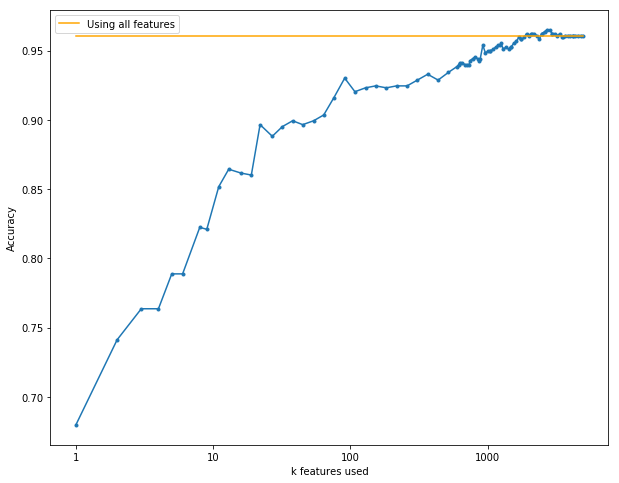

In [13]:
plt.figure(figsize=(10,8))
plt.plot(k_values, accuracies, marker='.')
plt.xscale('log')
plt.xlabel('k features used')
plt.minorticks_off()
plt.gca().get_xaxis().set_major_formatter(ScalarFormatter())
plt.ylabel('Accuracy')
using_all = accuracies[-1]
plt.plot(k_values,using_all*np.ones_like(k_values), color='orange', label='Using all features')
plt.legend()
plt.show()

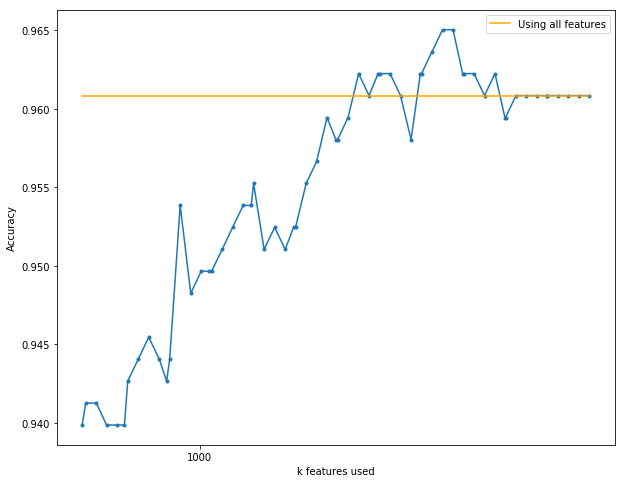

In [14]:
plt.figure(figsize=(10,8))
plt.plot(k_values[k_values>min_zoom], accuracies[k_values>min_zoom], marker='.')
plt.xscale('log')
plt.xlabel('k features used')
plt.minorticks_off()
plt.gca().get_xaxis().set_major_formatter(ScalarFormatter())
plt.ylabel('Accuracy')
using_all = accuracies[-1]
plt.plot(k_values[k_values>min_zoom], using_all*np.ones_like(k_values[k_values>min_zoom]), color='orange', label='Using all features')
plt.legend()
plt.show()

## Literature

<table>
    <tr>
        <td>
            <a name="IIR"></a>[IIR]
        </td>
        <td>
            Introduction To Information Retrieval
Christopher Manning-Prabhakar Raghavan-Hinrich Schütze - Cambridge University Press - 2009<br>Online version: https://nlp.stanford.edu/IR-book/information-retrieval-book.html
        </td>
    </tr>
    <tr>
        <td>
            <a name="SL"></a>[SL]
        </td>
        <td>
            Scikit-learn: Machine Learning in Python
Fabian Pedregosa, Gaël Varoquaux, Alexandre Gramfort, Vincent Michel, Bertrand Thirion, Olivier Grisel, Mathieu Blondel, Peter Prettenhofer, Ron Weiss, Vincent Dubourg, Jake Vanderplas, Alexandre Passos, David Cournapeau, Matthieu Brucher, Matthieu Perrot, Édouard Duchesnay; 12(Oct):2825−2830, 2011.
            <br>Website: https://scikit-learn.org
        </td>
    </tr>
      <tr>
        <td>
            <a name="VER14"></a>[VER14]
        </td>
        <td>
            Jorge R. Vergara, Pablo A. Estevez: A review of feature selection methods based on mutual information, Neural Comput & Applic (2014) 24:175–186
            <br>Website: http://repositorio.uchile.cl/bitstream/handle/2250/126533/A-review-of-feature-selection-methods-based-on-mutual-information.pdf
        </td>
    </tr>

</table>

## Licenses

### Notebook License (CC-BY-SA 4.0)

*The following license applies to the complete notebook, including code cells. It does however not apply to any referenced external media (e.g., images).*

Exercise - Mutual Information <br/>
by Diyar Oktay, Christian Herta, Klaus Strohmenger<br/>
is licensed under a [Creative Commons Attribution-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-sa/4.0/).<br/>
Based on a work at https://gitlab.com/deep.TEACHING.


### Code License (MIT)

*The following license only applies to code cells of the notebook.*

Copyright 2018 Diyar Oktay, Christian Herta, Klaus Strohmenger

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.